In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mcollections
import re
import tkinter as tk
from tkinter import filedialog
import numpy as np
import os
import traceback # エラー詳細表示用

In [2]:
# --- 4. matplotlibを用いたデータプロット関数 (再修正版) ---
def plot_nmr_data(filepath, total_residues, exclude_outliers=False, outlier_column=None, outlier_threshold=None):
    """
    指定されたCSVファイルからChemical_Shift_DifferenceとIntensity_Ratioを読み込み、
    Assignment列の残基番号を横軸にしてプロットします。
    残基番号の範囲をtotal_residuesで指定し、データがない残基は灰色で表示します。
    外れ値を除外する場合、指定された列と閾値に基づいて残基を除外し、灰色で表示します。
    Chemical_Shift_Differenceの上位10%の残基を特別な色で表示し、残基名を棒の上に表示します。
    ★最後に、未帰属残基と上位10%の残基番号を「別々に」PyMOL形式で出力します。
    """
    if not os.path.exists(filepath):
        print(f"エラー: ファイル '{filepath}' が存在しません。")
        return

    if not isinstance(total_residues, int) or total_residues <= 0:
        print(f"エラー: 無効なアミノ酸総数 '{total_residues}' です。正の整数を入力してください。")
        return

    print(f"\n--- NMRデータプロット処理開始 ---")
    print(f"対象ファイル: {os.path.basename(filepath)}")
    print(f"指定されたアミノ酸総数（X軸最大値）: {total_residues}")

    try:
        df = pd.read_csv(filepath, encoding='utf-8')

        print(f"\n--- 読み込んだデータの最初の数行 ---")
        print(df.head())

        required_cols = ['Assignment', 'Chemical_Shift_Difference', 'Intensity_Ratio']
        for col in required_cols:
            if col not in df.columns:
                print(f"エラー: '{os.path.basename(filepath)}' に必要な列 '{col}' が見つかりません。")
                return

        df['Residue_Number'] = df['Assignment'].apply(lambda x: re.search(r'\d+', str(x)).group(0) if re.search(r'\d+', str(x)) else None)
        df['Residue_Number'] = pd.to_numeric(df['Residue_Number'], errors='coerce')
        df.dropna(subset=['Residue_Number'], inplace=True)
        df.sort_values('Residue_Number', inplace=True)
        df['Residue_Number'] = df['Residue_Number'].astype(int)

        if df.empty:
            print("エラー: 処理できるデータが見つかりませんでした。Assignment列の形式を確認してください。")
            return

        all_residues = set(range(1, total_residues + 1))
        present_residues = set(df['Residue_Number'].unique())
        # 「未帰属残基」のセットを定義
        missing_residues_initial = all_residues - present_residues
        
        excluded_outlier_residues = set()

        if exclude_outliers and outlier_column and outlier_threshold is not None:
            if outlier_column not in df.columns:
                print(f"警告: 指定された外れ値対象列 '{outlier_column}' がデータフレームに存在しません。外れ値除外はスキップされます。")
            elif outlier_column not in required_cols[1:]:
                print(f"警告: 指定された外れ値対象列 '{outlier_column}' は数値データ列ではありません。'Chemical_Shift_Difference' または 'Intensity_Ratio' を指定してください。外れ値除外はスキップされます。")
            else:
                initial_df_len = len(df)
                outlier_mask = (df[outlier_column] > outlier_threshold)
                excluded_outlier_residues = set(df.loc[outlier_mask, 'Residue_Number'].unique())
                df = df[~outlier_mask]
                
                print(f"\n--- 外れ値除外情報 ---")
                print(f"対象列: '{outlier_column}', 閾値: > {outlier_threshold}")
                print(f"外れ値として除外された残基数: {len(excluded_outlier_residues)}")
                print(f"除外された残基番号: {sorted(list(excluded_outlier_residues))}")
                print(f"外れ値除外後のデータ行数: {len(df)} (元: {initial_df_len})")

        all_excluded_residues = missing_residues_initial.union(excluded_outlier_residues)

        missing_ranges = []
        if all_excluded_residues:
            sorted_excluded = sorted(list(all_excluded_residues))
            start = sorted_excluded[0]
            end = sorted_excluded[0]
            for i in range(1, len(sorted_excluded)):
                if sorted_excluded[i] == end + 1:
                    end = sorted_excluded[i]
                else:
                    missing_ranges.append((start, end))
                    start = sorted_excluded[i]
                    end = sorted_excluded[i]
            missing_ranges.append((start, end))

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

        chemical_shift_label = (
            'Chemical Shift Difference\n'
            r'$\Delta\delta = \sqrt{(\delta H_{\text{free}} - \delta H_{\text{bound}})^2 + \left(\frac{\delta N_{\text{free}} - \delta N_{\text{bound}}}{5}\right)^2}$'
        )
        
        ax1.bar(df['Residue_Number'], df['Chemical_Shift_Difference'], color='blue', label=chemical_shift_label, width=0.8, align='center')
        
        top_10_percent_residues_set = set()

        if not df.empty:
            top_10_percent_count = int(len(df) * 0.10)
            if top_10_percent_count == 0 and len(df) > 0:
                top_10_percent_count = 1
            
            df_sorted_csd = df.sort_values(by='Chemical_Shift_Difference', ascending=False)
            top_10_percent_residues_df = df_sorted_csd.head(top_10_percent_count)
            
            # 上位10%の残基番号をセットに格納
            top_10_percent_residues_set = set(top_10_percent_residues_df['Residue_Number'])

            ax1.bar(top_10_percent_residues_df['Residue_Number'], top_10_percent_residues_df['Chemical_Shift_Difference'],
                    color='orange', width=0.8, align='center', label='Top 10% Chemical Shift Difference')
            
            for index, row in top_10_percent_residues_df.iterrows():
                cleaned_assignment = row['Assignment'][:-3] 
                ax1.text(row['Residue_Number'], row['Chemical_Shift_Difference'],
                         cleaned_assignment, ha='center', va='bottom', fontsize=12, color='black', rotation=45)

        ax1.set_ylabel('Chemical Shift Difference (ppm)')
        ax1.set_title(f'NMR Data Analysis: {os.path.basename(filepath)}')
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend(loc='upper right', fontsize='x-large')
        ax1.set_xlim(0.5, total_residues + 0.5)
        ax1.set_xticks(np.arange(1, total_residues + 1, 10))
        ax1.set_xticklabels(np.arange(1, total_residues + 1, 10))

        intensity_ratio_label = (
            'Intensity Ratio\n'
            r'$ file1 / file2 $'
        )
        ax2.bar(df['Residue_Number'], df['Intensity_Ratio'], color='red', label=intensity_ratio_label, width=0.8, align='center')
        ax2.set_xlabel('Residue Number')
        ax2.set_ylabel('Intensity Ratio')
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(loc='upper right', fontsize='x-large')
        ax2.set_xlim(0.5, total_residues + 0.5)
        ax2.set_xticks(np.arange(1, total_residues + 1, 10))
        ax2.set_xticklabels(np.arange(1, total_residues + 1, 10))

        for start_res, end_res in missing_ranges:
            ax1.axvspan(start_res - 0.5, end_res + 0.5, facecolor='lightgray', alpha=0.6, zorder=0)
            ax2.axvspan(start_res - 0.5, end_res + 0.5, facecolor='lightgray', alpha=0.6, zorder=0)
            
        # --- 変更点：ここからPyMOL用出力コード (分離版) ---
        print("\n" + "="*60)
        print("--- PyMOL Selection Strings ---")

        # 1. 未帰属残基の出力
        print("\n[1] 未帰属残基 (Unassigned / Missing Residues)")
        if missing_residues_initial:
            sorted_missing = sorted(list(missing_residues_initial))
            missing_string = "+".join(map(str, sorted_missing))
            print(missing_string)
        else:
            print("該当なし (None)")

        # 2. CSD上位10%残基の出力
        print("\n[2] CSD上位10%の残基 (Top 10% CSD Residues)")
        if top_10_percent_residues_set:
            sorted_top10 = sorted(list(top_10_percent_residues_set))
            top10_string = "+".join(map(str, sorted_top10))
            print(top10_string)
        else:
            print("該当なし (None)")
        
        print("\n" + "="*60)
        # --- 変更点：ここまで ---

        plt.tight_layout()
        plt.show()

        print(f"\n--- NMRデータプロット処理完了 ---")

    except Exception as e:
        print(f"ファイルの読み込みまたはプロット中にエラーが発生しました: {e}")
        traceback.print_exc()

--- NMRデータプロットスクリプト開始 ---

--- プロットするCSVファイルを選択してください。（通常は計算結果ファイル） ---
タンパク質のアミノ酸総数（残基の最大番号）を入力してください: 169
外れ値を除外しますか？ (y/n): n

--- NMRデータプロット処理開始 ---
対象ファイル: 100_GMPPNPvsGDP.csv
指定されたアミノ酸総数（X軸最大値）: 169

--- 読み込んだデータの最初の数行 ---
  Assignment  w1_file1  w2_file1  Data Height_file1  w1_file2  w2_file2  \
0      T2N-H   122.240     8.517             377924   122.098     8.519   
1      E3N-H   126.853     8.304             352773   126.709     8.314   
2      Y4N-H   121.801     8.757             257450   122.011     8.723   
3      K5N-H   124.585     9.137             295339   123.780     9.121   
4      L6N-H   126.845     9.562             221291   126.387     9.238   

   Data Height_file2  w1_diff  w2_diff  Chemical_Shift_Difference  \
0            1658692    0.142   -0.002                   0.028470   
1            1633204    0.144   -0.010                   0.030487   
2             807546   -0.210    0.034                   0.054037   
3            1147323    0.805    0.016      

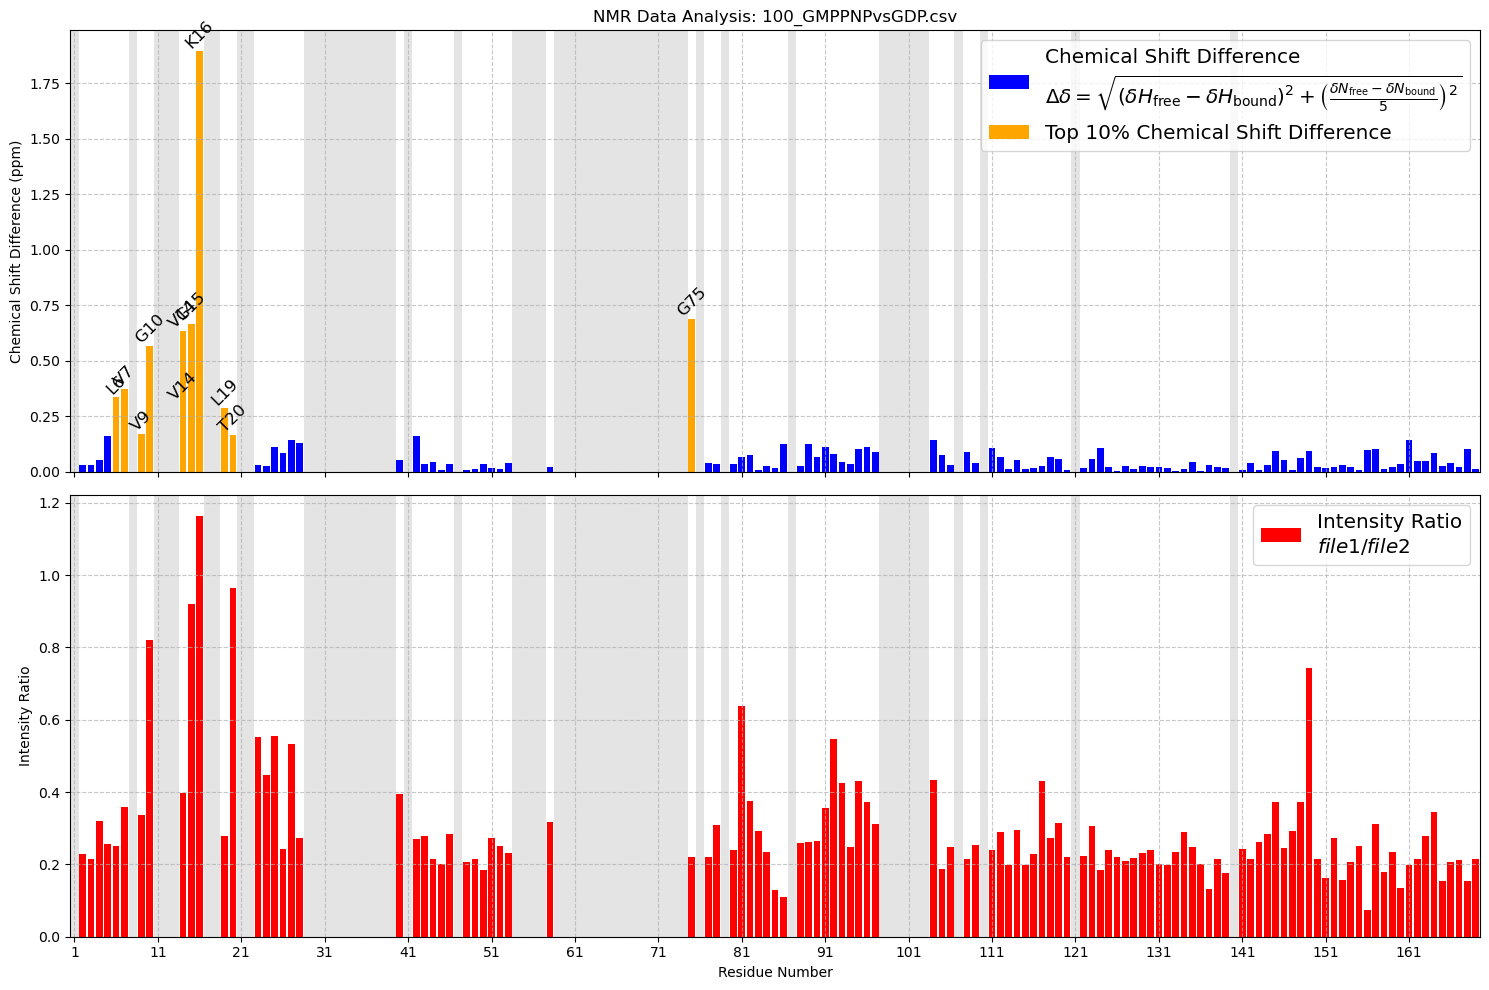


--- NMRデータプロット処理完了 ---

--- スクリプト終了 ---


In [3]:
# --- メイン実行ブロック（プロット部分のみ） ---
if __name__ == "__main__":
    # Tkinterのルートウィンドウを作成（非表示）
    root = tk.Tk()
    root.withdraw()

    print("--- NMRデータプロットスクリプト開始 ---")

    # --- フェーズ3: データプロット ---
    print("\n--- プロットするCSVファイルを選択してください。（通常は計算結果ファイル） ---")
    file_path_to_plot = filedialog.askopenfilename(title="プロット対象のCSVファイルを選択してください", filetypes=[("CSV files", "*.csv"), ("All files", "*.*")])
    
    if file_path_to_plot:
        while True:
            try:
                total_residues_input = input("タンパク質のアミノ酸総数（残基の最大番号）を入力してください: ")
                total_residues = int(total_residues_input)
                if total_residues <= 0:
                    print("エラー: 0より大きい整数を入力してください。")
                else:
                    break
            except ValueError:
                print("エラー: 無効な入力です。整数を入力してください。")

        # 外れ値除外に関するユーザー入力
        exclude_outliers_choice = input("外れ値を除外しますか？ (y/n): ").lower()
        exclude_outliers = (exclude_outliers_choice == 'y')

        outlier_col = None
        outlier_thresh = None

        # --- ▼▼▼ ここからが変更箇所 ▼▼▼ ---
        if exclude_outliers:
            # 列名の選択をなくし、'Chemical_Shift_Difference' に固定
            outlier_col = 'Chemical_Shift_Difference'
            print(f"-> 外れ値の対象列は '{outlier_col}' に固定されています。")
            
            # 閾値の入力のみをユーザーに要求
            while True:
                try:
                    outlier_thresh_input = input(f"'{outlier_col}' の外れ値のしきい値 (> この値) を入力してください (例: 0.5): ")
                    outlier_thresh = float(outlier_thresh_input)
                    break
                except ValueError:
                    print("エラー: 無効な入力です。数値を入力してください。")
        # --- ▲▲▲ ここまでが変更箇所 ▲▲▲ ---

        # plot_nmr_data 関数を呼び出し (外れ値パラメータを追加)
        plot_nmr_data(file_path_to_plot, total_residues,
                      exclude_outliers=exclude_outliers,
                      outlier_column=outlier_col,
                      outlier_threshold=outlier_thresh)
    else:
        print("プロットするファイルが選択されませんでした。処理を終了します。")

    print("\n--- スクリプト終了 ---")